In [1]:
import numpy as np, humanfriendly as hf
import time
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [12]:
def see_time(note,start):
    end = time.perf_counter()
    elapsed = end - start
    print (note,hf.format_timespan(elapsed, detailed=True))

In [3]:
def get_cross(model, data, target, groups=10):
    return cross_val_score(model, data, target, cv=groups)

In [4]:
X = np.load('data/X_faces.npy')
y = np.load('data/y_faces.npy')
images = np.load('data/faces_images.npy')
targets = np.load('data/faces_targets.npy')

In [6]:
_, h, w = images.shape
n_images, n_features, n_classes = X.shape[0], X.shape[1],len(targets)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [8]:
pca = PCA(n_components=0.95, whiten=True, random_state=0)
pca_name = pca.__class__.__name__
pca.fit(X_train)
components = pca.n_components_
eigenfaces = pca.components_.reshape((components, h, w))
X_train_pca = pca.transform(X_train)
print (pca_name + 'features (before PCA):', n_features,'features (after PCA):', components)

PCAfeatures (before PCA): 1850 features (after PCA): 135


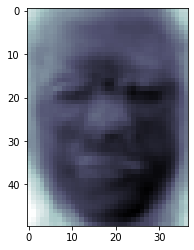

In [9]:
X_i = np.array(eigenfaces[0].reshape(h, w))
fig = plt.figure('eigenface')
ax = fig.subplots()
image = ax.imshow(X_i, cmap='bone')

In [11]:
svm_model = SVC(random_state=0, gamma='scale')
svm_model_name = svm_model.__class__.__name__   
svm_model.fit(X_train_pca, y_train)
X_test_pca = pca.transform(X_test)
y_pred = svm_model.predict(X_test_pca)
cr = classification_report(y_test, y_pred)
print (cr)

              precision    recall  f1-score   support

           0       1.00      0.43      0.60        28
           1       0.83      0.87      0.85        63
           2       0.94      0.62      0.75        24
           3       0.71      0.97      0.82       132
           4       1.00      0.70      0.82        20
           5       1.00      0.36      0.53        22
           6       0.96      0.73      0.83        33

    accuracy                           0.80       322
   macro avg       0.92      0.67      0.74       322
weighted avg       0.84      0.80      0.78       322



In [14]:
param_grid = {'C': [1e2, 1e3, 5e3],
              'gamma': [0.001, 0.005, 0.01, 0.1],
              'kernel': ['rbf'],
              'class_weight': ['balanced']}
grid = GridSearchCV(svm_model, param_grid, cv=5)
start = time.perf_counter()
grid.fit(X_train_pca, y_train)
see_time('training time:',start)
bp = grid.best_params_
print ('best parameters:',bp)

training time: 11 seconds, 538 milliseconds, 690 microseconds and 100 nanoseconds
best parameters: {'C': 100.0, 'class_weight': 'balanced', 'gamma': 0.005, 'kernel': 'rbf'}


In [15]:
svm_model = SVC(**bp)
svm_model.fit(X_train_pca, y_train)
y_pred = svm_model.predict(X_test_pca)
cr = classification_report(y_test, y_pred)
print (cr)

              precision    recall  f1-score   support

           0       1.00      0.64      0.78        28
           1       0.76      0.92      0.83        63
           2       0.91      0.88      0.89        24
           3       0.88      0.92      0.90       132
           4       0.74      0.85      0.79        20
           5       1.00      0.64      0.78        22
           6       0.90      0.85      0.88        33

    accuracy                           0.86       322
   macro avg       0.89      0.81      0.84       322
weighted avg       0.87      0.86      0.86       322



In [17]:
scores = get_cross(svm_model, X_train_pca, y_train)
print ('cross-validation:',np.mean(scores))

cross-validation: 0.8393624737627647


In [18]:
file = 'data/bp_face'
np.save(file, bp)

In [19]:
# 查看
bp = np.load('data/bp_face.npy', allow_pickle=True)
bp = bp.tolist()
print ('best parameters:',bp)

best parameters: {'C': 100.0, 'class_weight': 'balanced', 'gamma': 0.005, 'kernel': 'rbf'}
